In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from matplotlib.dates import *
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import modules.radarmodule as radar
import modules.simulator as sim
import modules.plotmodule as pm
from modules.datahandler import getDataHandler
#import obanmodule as oban
import pandas as pd
import glob
import pyart as pyart
from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from metpy.plots import ctables
%matplotlib notebook
%load_ext autoreload
%autoreload 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [6]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis

# Could be one of '060509', '060709', or '060909', currently
casedate = '060909'

# List of field names to read
fieldnames = ['dBZ']
# Requested elevation angle
el_req = 0.5

# Note: the feature_* parameters in the dictionary are manually derived locations (radar relative) of some feature
# in the radar data that are used to compute the storm motion. In the 060509 case, I'm using the location of the
# inflow notch (similar to French et al. 2012). Other features may be more appropriate for the other cases.

radar_dict = {'060509': {'feature_start_loc': (30., 57.), 'feature_end_loc': (58., 53.),
                         'feature_start_time': datetime(2009, 6, 5, 21, 57, 43),
                         'feature_end_time': datetime(2009, 6, 5, 22, 43, 29),
                         'sweeptime_ref': datetime(2009, 6, 5, 22, 2, 18),
                         'radardir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/nexrad',
                         'fieldnames': fieldnames,
                         'el_req': el_req,
                         'radstarttime': '20090605215500',
                         'radstoptime': '20090605224500'},
              '060709': {'feature_start_loc': (-94., 138.), 'feature_end_loc': (-75., 132.),
                         'feature_start_time': datetime(2009, 6, 7, 23, 16, 34),
                         'feature_end_time': datetime(2009, 6, 7, 23, 43, 54),
                         'sweeptime_ref': datetime(2009, 6, 7, 23, 34, 32),
                         'radardir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060709/nexrad',
                         'fieldnames': fieldnames,
                         'el_req': el_req,
                         'radstarttime': '20090607231500',
                         'radstoptime': '20090608001000'},
              '060909': {'feature_start_loc': (16., -5.), 'feature_end_loc': (37., -8.),
                         'feature_start_time': datetime(2009, 6, 9, 23, 16, 20),
                         'feature_end_time': datetime(2009, 6, 9, 23, 39, 31),
                         'sweeptime_ref': datetime(2009, 6, 9, 23, 29, 59),
                         'radardir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad',
                         'fieldnames': fieldnames,
                         'el_req': el_req,
                         'radstarttime': '20090609231500',
                         'radstoptime': '20090610000000'}}

dis_dict = {'060509': {'dis_dir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060509/dsdprobes/',
                       'dis_types': ['CU', 'CU', 'NV2', 'NV2'],
                       'dis_names': ['CU1', 'CU2', 'P1', 'P2'],
                       'disfilenames': ['20090605_PA01.txt', 
                                        '20090605_PA02.txt', 
                                        '2009_06_05_D1_DIS_P1.nc', 
                                        '2009_06_05_D1_DIS_P2.nc'],
                       'convfilenames': ['20090605_CU1.dat', 
                                         '20090605_CU2.dat', 
                                         '2009_06_05_D1_TRP_P1.nc', 
                                         '2009_06_05_D1_TRP_P2.nc'],
                       'starttimes': ['20090605215500', '20090605213500', '20090605215500', '20090605215500'],
                       'stoptimes': ['20090605224500', '20090605224500', '20090605224500', '20090605224500']},
            '060709': {'dis_dir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060709/dsdprobes/',
                       'dis_types': ['CU', 'NV2', 'NV2'],
                       'dis_names': ['CU2', 'P1', 'P2'],
                       'disfilenames': ['20090607_PA02.txt', 
                                        '2009_06_07_D1_DIS_P1.nc', 
                                        '2009_06_07_D1_DIS_P2.nc'],
                       'convfilenames': ['20090607_CU2.dat', 
                                         '2009_06_07_D1_TRP_P1.nc', 
                                         '2009_06_07_D1_TRP_P2.nc'],
                       'starttimes': ['20090607231700', '20090607233800', '20090607233000'],
                       'stoptimes': ['20090607232900', '20090608000400', '20090607235800']},
            '060909': {'dis_dir': '/Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/dsdprobes/',
                       'dis_types': ['CU', 'CU', 'NV2', 'NV2'],
                       'dis_names': ['CU1', 'CU2', 'P1', 'P2'],
                       'disfilenames': ['20090609_PA01.txt',
                                        '20090609_PA02.txt', 
                                        '2009_06_09_D1_DIS_P1.nc', 
                                        '2009_06_09_D1_DIS_P2.nc'],
                       'convfilenames': ['20090609_CU1.dat',
                                         '20090609_CU2.dat', 
                                         '2009_06_09_D1_TRP_P1.nc', 
                                         '2009_06_09_D1_TRP_P2.nc'],
                       'starttimes': ['20090609232500', '20090609233800', '20090609232300', '20090609233000'],
                       'stoptimes': ['20090609234600', '20090609234500', '20090609234800', '20090609234300']}}

model_dict = {'060509': {'runname': 'jun05ZVDH3MCCN1imlt2_mod_nz61', 'modeltimesec_ref': 8640., 'probe_ref': 'P2', 
                         'ref_coords': (41500., 55500.), 'microphys': 'ZVD', 'model_dt': 120.,
                         'dirname': '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060509/1km/'},
              '060709': {'runname': 'jun07ZVDH3MCCN1imlt2_nz61', 'modeltimesec_ref': 7080., 'probe_ref': 'P2', 
                         'ref_coords': (37500., 57500.), 'microphys': 'ZVD', 'model_dt': 120.,
                         'dirname': '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060709/1km/'},
              '060909': {'runname': 'jun09ZVDH3MCCN1imlt2_nz61', 'modeltimesec_ref': 5760., 'probe_ref': 'P2', 
                         'ref_coords': (40500., 45500.), 'microphys': 'ZVD', 'model_dt': 120.,
                         'dirname': '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060909/1km/'}}

# Define functions to manipulate and read radar, disdrometer, and model data
def read_sweeps(casedate, radar_dict):
    """Reads sweeps from CFRadial files for a case as defined in the radar_dict dictionary.
       Stuffs these sweeps into the dictionary"""
    # Initial latitude, longitude, altitude set to None (will be read from files)
    radlat = None
    radlon = None
    radalt = None
    radardir = radar_dict[casedate]['radardir']
    radpathlist = glob.glob(radardir+'/*nc')
    radstarttime = radar_dict[casedate]['radstarttime']
    radstoptime = radar_dict[casedate]['radstoptime']
    
    # Now read in all the sweeps between radstarttime and radstoptime closest to the requested
    # elevation angle
    radstarttimedt = datetime(np.int(radstarttime[:4]), np.int(radstarttime[4:6]), np.int(
            radstarttime[6:8]), np.int(radstarttime[8:10]), np.int(radstarttime[10:12]))
    radstoptimedt = datetime(np.int(radstoptime[:4]), np.int(radstoptime[4:6]), np.int(
            radstoptime[6:8]), np.int(radstoptime[8:10]), np.int(radstoptime[10:12]))
    
    outfieldnameslist = []
    radarsweeplist = []
    sweeptimelist = []
    
    for radpath in radpathlist:
        sweeptime = radar._getsweeptime(radpath)
    
        if(radstarttimedt <= sweeptime and sweeptime <= radstoptimedt):
            outfieldnames, radarsweep = radar.readCFRadial_pyART(False, el_req, radlat, radlon, radalt, radpath, 
                                                                 None, fieldnames, compute_kdp=False)
            outfieldnameslist.append(outfieldnames)
            radarsweeplist.append(radarsweep)
            sweeptimelist.append(sweeptime)
    
    # Stuff the lists into the dictionary
    radar_dict[casedate]['outfieldnameslist'] = outfieldnameslist
    radar_dict[casedate]['radarsweeplist'] = radarsweeplist
    radar_dict[casedate]['sweeptimelist'] = sweeptimelist
    
def compute_storm_motion(radar_dict):
    """Computes storm motion from start and end points of a given feature.
       Adds a new key to the given dictionary with the storm motion vector
       in a tuple."""
    for casedate, case in radar_dict.iteritems():
        deltat = (case['feature_end_time'] - case['feature_start_time']).total_seconds()
        ustorm = (case['feature_end_loc'][0] - case['feature_start_loc'][0]) * 1000. / deltat
        vstorm = (case['feature_end_loc'][1] - case['feature_start_loc'][1]) * 1000. / deltat
        case['feature_motion'] = (ustorm, vstorm)

def read_convdata_at_sweeptimes(casedate, dis_dict, radar_dict):
    """Reads in the conventional data from the probes for the given case and stuffs it into the dis_dict dictionary"""
    deployedlist = []
    windspdlist = []
    windspdavgveclist = []
    winddirabslist = []
    winddiravgveclist = []
    templist = []
    dewpointlist = []
    pressurelist = []

    # Extract stuff from dictionary
    dis_types = dis_dict[casedate]['dis_types']
    disfilenames = dis_dict[casedate]['disfilenames']
    convfilenames = dis_dict[casedate]['convfilenames']
    starttimes = dis_dict[casedate]['starttimes']
    stoptimes = dis_dict[casedate]['stoptimes']
    dis_dir = dis_dict[casedate]['dis_dir']
    
    for dis_type, disfilename, convfilename, starttime, stoptime in zip(dis_types, disfilenames, convfilenames, 
                                                                        starttimes, stoptimes):
    
        dis_filepath = os.path.join(dis_dir, disfilename)
        conv_filepath = os.path.join(dis_dir, convfilename)

        if dis_type in 'CU':

            DSD_dict = dis.readCU(conv_filepath, dis_filepath, requested_interval=60.0,
                                   starttime=starttime, stoptime=stoptime)
            windspdstr = 'bwindspd'
            winddirstr = 'bwinddirabs'
        elif dis_type in 'NV2':
            DSD_dict = dis.readNV2netCDF(conv_filepath, dis_filepath, requested_interval=60.0, 
                                          starttime=starttime, stoptime=stoptime)
            windspdstr = 'swindspd'
            winddirstr = 'swinddirabs'

        # Extract conventional data series (1-s interval)
        conv_df = DSD_dict['conv_df']
        windspds = conv_df[windspdstr].values
        winddirabss = conv_df[winddirstr].values
        temps = conv_df['slowtemp'].values
        dewpoints = conv_df['dewpoint'].values
        pressures = conv_df['pressure'].values

        # Plot wind meteogram
        windavgintv = 60
        windgustintv = 3

        # Compute wind speed and direction, and wind gusts
        if dis_type in 'NV2':
            windspdsavg = windspds
            windspdsavgvec = windspds
            windgustsavg = conv_df['swindgust'].values
            winddirsavgvec = winddirabss
        elif dis_type in 'CU':
            windspdsavg,windspdsavgvec,winddirsavgvec,windgusts,windgustsavg = dis.avgwind(winddirabss,
                windspds,windavgintv,gusts=True,gustintv=windgustintv,center=False)
    #     offset = 0
    #     windspdsavg,windspdsavgvec,winddirsavgvec,winddirsunitavgvec,windgusts,windgustsavg,usavg,vsavg,unit_usavg,unit_vsavg = \
    #     dis.resamplewind(datetimesUTC,offset,winddirabss,windspds,'60S',gusts=True,gustintvstr='3S',center=False)

        datetimesUTC = DSD_dict['convtimestamps']
        datetimesUTCnums = date2num(datetimesUTC)

        deployedtlist = []
        windspdtlist = []
        windspdavgvectlist = []
        winddirabstlist = []
        winddiravgvectlist = []
        temptlist = []
        dewpointtlist = []
        pressuretlist = []

        # Find the times closest to the sweeptimes
        for sweeptime in radar_dict[casedate]['sweeptimelist']:
            try:
                index = next(i for i, t in enumerate(datetimesUTC) if np.abs((t-sweeptime).total_seconds()) <= 10.)
                deployedtlist.append(True)
            except:
                index = None
                deployedtlist.append(False)
    
            if index is not None:
                windspdtlist.append(windspds[index])
                winddirabstlist.append(winddirabss[index])
                temptlist.append(temps[index])
                dewpointtlist.append(dewpoints[index])
                pressuretlist.append(pressures[index])
                windspdavgvectlist.append(windspdsavgvec[index])
                winddiravgvectlist.append(winddirsavgvec[index])
            else:
                windspdtlist.append(np.nan)
                winddirabstlist.append(np.nan)
                temptlist.append(np.nan)
                dewpointtlist.append(np.nan)
                pressuretlist.append(np.nan)
                windspdavgvectlist.append(np.nan)
                winddiravgvectlist.append(np.nan)

        deployedarr = np.array(deployedtlist)
        windspdarr = np.array(windspdtlist)
        winddirabsarr = np.array(winddirabstlist)
        temparr = np.array(temptlist)
        dewpointarr = np.array(dewpointtlist)
        pressurearr = np.array(pressuretlist)
        windspdavgvecarr = np.array(windspdavgvectlist)
        winddiravgvecarr = np.array(winddiravgvectlist)

        deployedlist.append(deployedarr)
        windspdlist.append(windspdarr)
        windspdavgveclist.append(windspdavgvecarr)
        winddirabslist.append(winddirabsarr)
        winddiravgveclist.append(winddiravgvecarr)
        templist.append(temparr)
        dewpointlist.append(dewpointarr)
        pressurelist.append(pressurearr)

    # Stuff all the data into the dis_dict dictionary
    dis_dict[casedate]['convdata_at_sweeptimes'] = {'windspd': windspdlist, 'windspdavgvec': windspdavgveclist,
                                                    'winddirabs': winddirabslist, 'winddiravgvec': winddiravgveclist, 
                                                    'temp': templist, 'dewpoint': dewpointlist, 
                                                    'pressure': pressurelist, 'deployed': deployedlist}

def get_dis_locs_relative_to_radar(casedate, dis_dict, radar_dict):
    """Gets the disdrometer locations relative to the radar."""
    dgeoloclist = []
    dradloclist = []
    # Extract parameters from dictionary
    dis_names = dis_dict[casedate]['dis_names']
    dis_types = dis_dict[casedate]['dis_types']
    disfilenames = dis_dict[casedate]['disfilenames']
    convfilenames = dis_dict[casedate]['convfilenames']
    starttimes = dis_dict[casedate]['starttimes']
    stoptimes = dis_dict[casedate]['stoptimes']
    dis_dir = dis_dict[casedate]['dis_dir']
    
    for dis_name, dis_filename, conv_filename, starttime, stoptime, dis_type in \
            zip(dis_names, disfilenames, convfilenames, starttimes, stoptimes, dis_types):
        filepath = os.path.join(dis_dir, dis_filename)
        if(dis_type == 'PIPS'):
            GPS_lats, GPS_lons, GPS_stats, GPS_alts, dgeoloc = dis.readPIPSloc(filepath)
        elif(dis_type == 'CU'):
            convfilepath = os.path.join(dis_dir, conv_filename)
            GPS_lats, GPS_lons, GPS_stats, GPS_alts, dgeoloc = dis.readCUloc(convfilepath,
                                                                          starttime=starttime,
                                                                          stoptime=stoptime)
        elif(dis_type == 'NV2'):
            dgeoloc = dis.readNV2loc(filepath)

        dradx, drady = pyart.core.geographic_to_cartesian_aeqd(dgeoloc[1], dgeoloc[0], rlon, rlat)
        dx = dradx[0]
        dy = drady[0]
        print dx, dy

        dgeoloclist.append(dgeoloc)
        dradloclist.append((dx, dy))
    
    # Stuff the locations into the dis_dict dictionary
    dis_dict[casedate]['dgeoloclist'] = dgeoloclist
    dis_dict[casedate]['dradloclist'] = dradloclist
    
def set_dh(casedate, model_dict, radar_dict, fixed_time=True, multitime=True):
    """Reads a DataHandler instance for COMMAS simulation output given information in model_dict, using
       casedate as the key. Puts the DataHandler instance into model_dict. Also associates
       the reference time of the model simulation with that of the reference sweep in radar_dict"""
    modelname = 'COMMAS'
    runname = model_dict[casedate]['runname']
    dirname = model_dict[casedate]['dirname']
    model_dt = model_dict[casedate]['model_dt']
    # For now, only read one time, corresponding to the desired reference time
    modeltimesec_ref = model_dict[casedate]['modeltimesec_ref']
    model_times = [modeltimesec_ref]
    microphys = model_dict[casedate]['microphys']
    dh = getDataHandler(modelname, dirname, model_times, microphys, multitime=multitime)
    dh.setRun(runname, 0)
    dh.loadTimes()
    dh.setTime(modeltimesec_ref)
    modeltime_ref = radar_dict[casedate]['sweeptime_ref']
    model_dict[casedate]['DataHandler'] = dh
    model_dict[casedate]['modeltime_ref'] = modeltime_ref

In [7]:
# Now go ahead and read in the sweeps for the desired case
read_sweeps(casedate, radar_dict)

# Compute the storm motion
compute_storm_motion(radar_dict)
print radar_dict[casedate]['feature_motion']

/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_ST

Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_231620_030_KDDC_v467_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:16:20 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_232057_949_KDDC_v468_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.57128906
Time of sweep =  2009-06-09 23:20:57 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_232537_231_KDDC_v469_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:25:37 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_233015_093_KDDC_v470_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:30:15 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_233452_846_KDDC_v471_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:34:52 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_233931_154_KDDC_v472_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:39:31 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_234409_410_KDDC_v473_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:44:09 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_234849_482_KDDC_v474_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:48:49 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_235327_551_KDDC_v475_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:53:27 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/Projects/VORTEX2/model_DSD_study/obsdata/060909/nexrad/cfrad.20090609_235806_923_KDDC_v476_SUR.nc


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.52734375
Time of sweep =  2009-06-09 23:58:06 
Number of gates:  1832
Radar lat,lon,alt [37.760833740234375] [-99.96888732910156] [809.0]
Gatewidth  250.0
Radar beam width (degrees): 0.91
Number of azimuths in sweep  720
(15.097052480230051, -2.156721782890007)


/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/anaconda2/lib/python2.7/site-packages/PyNIO/Nio.py:366: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_ST

37.760833740234375 -99.96888732910156
{'proj': 'pyart_aeqd', '_include_lon_0_lat_0': True}
Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
Requested DSD interval: 60.0. Actual DSD interval: 60.0
29626.235560761364 -9833.153474848443
29643.749149794952 -10721.33234893632
lat =  37.6611175537
28795.508 -11037.975
lat =  37.6685752869
29626.44 -10205.392
i, sweeptime =  2009-06-09 23:16:20


<IPython.core.display.Javascript object>


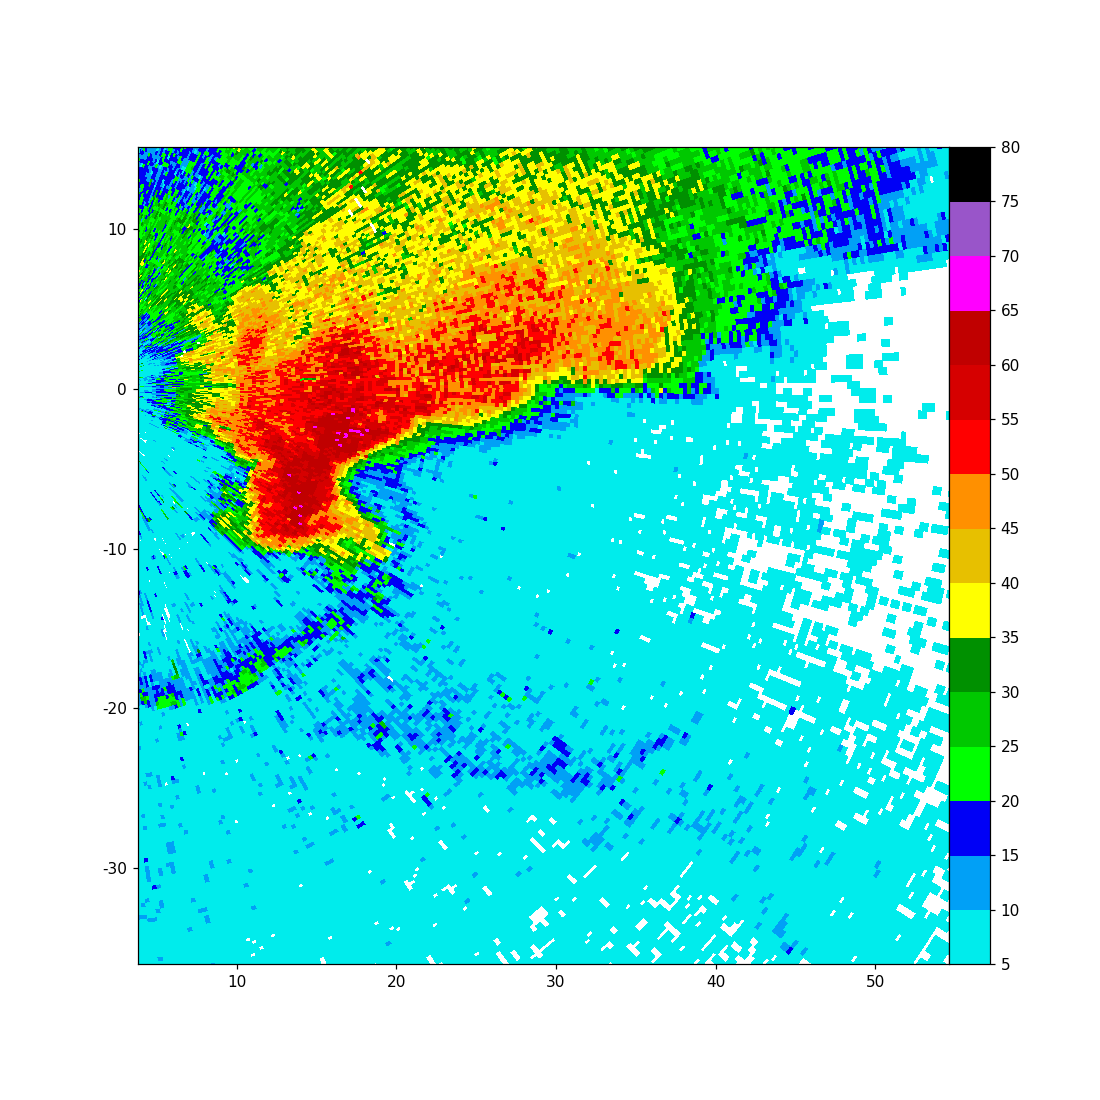

i, sweeptime =  2009-06-09 23:20:57


<IPython.core.display.Javascript object>


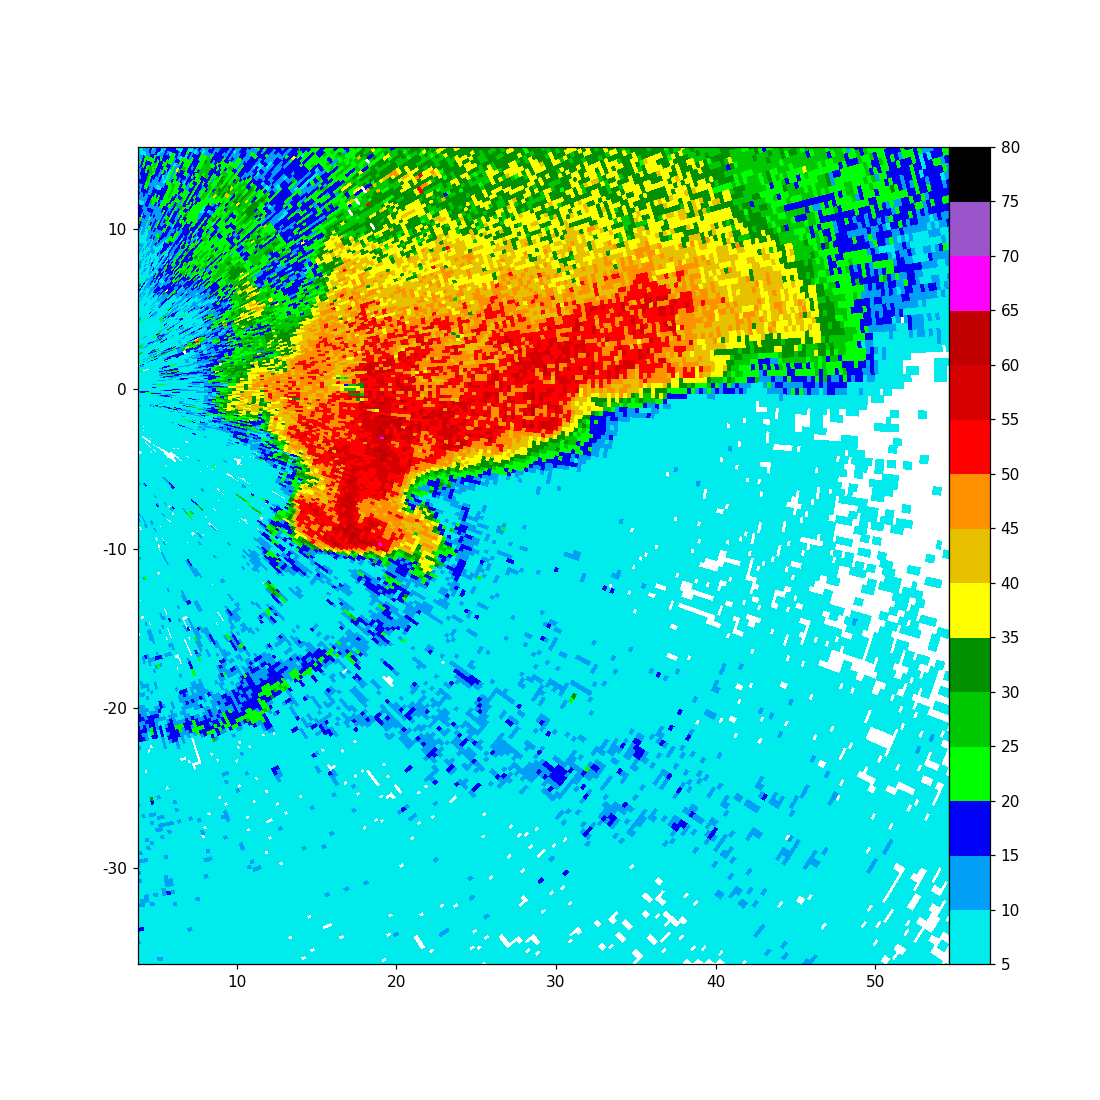

i, sweeptime =  2009-06-09 23:25:37


<IPython.core.display.Javascript object>


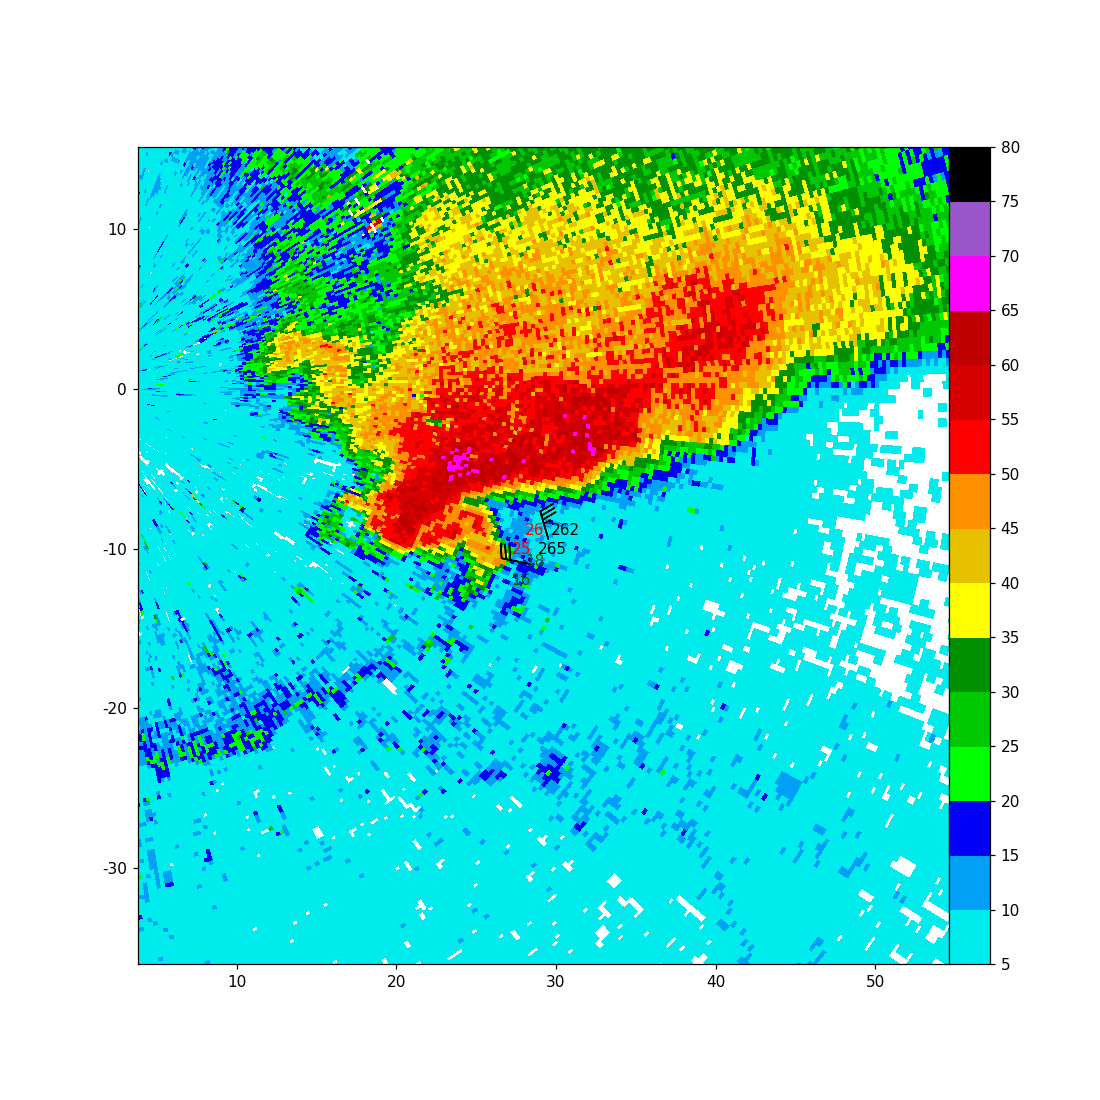

i, sweeptime =  2009-06-09 23:30:15


<IPython.core.display.Javascript object>


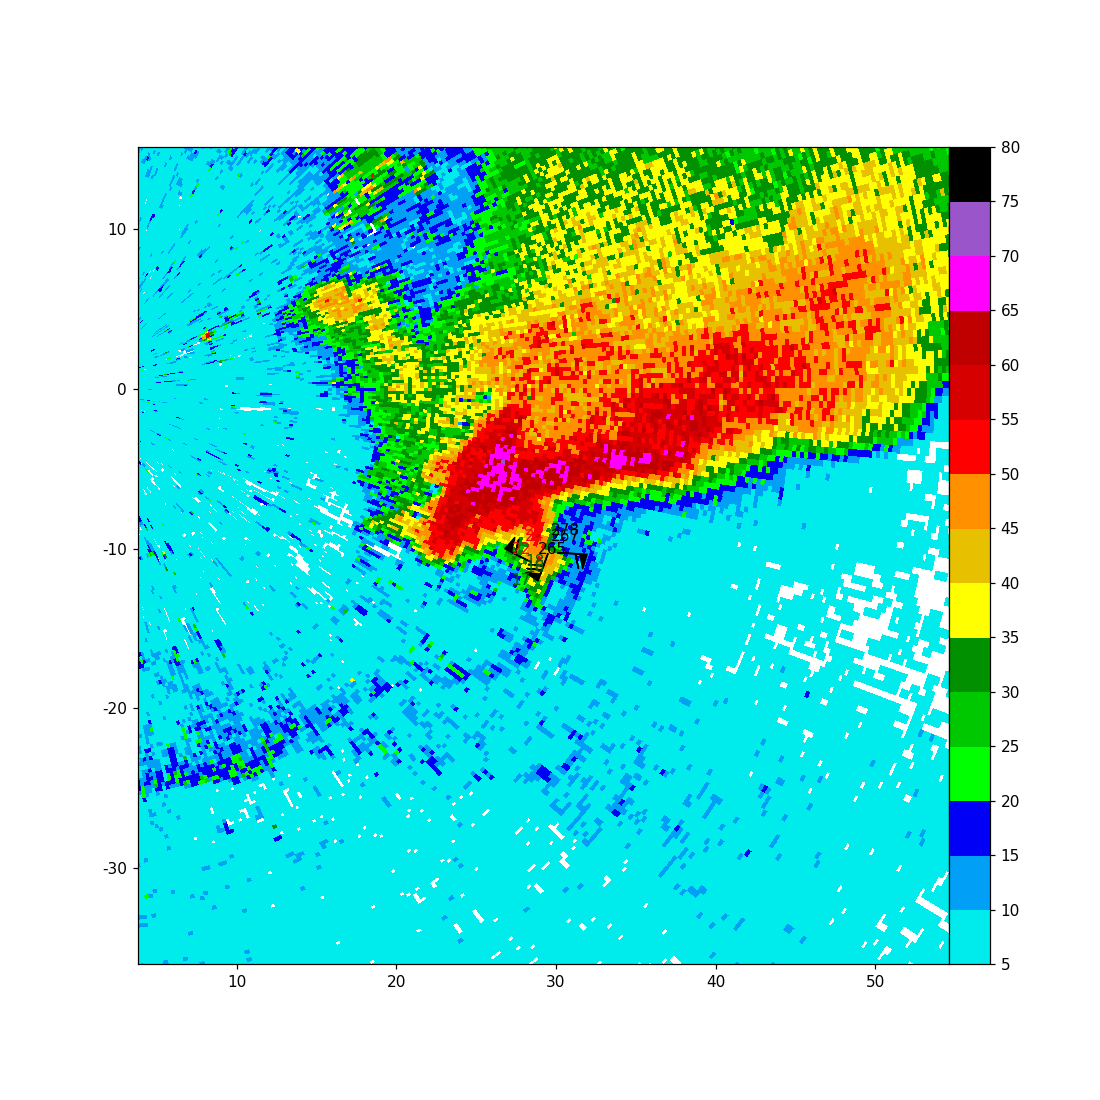

i, sweeptime =  2009-06-09 23:34:52


<IPython.core.display.Javascript object>


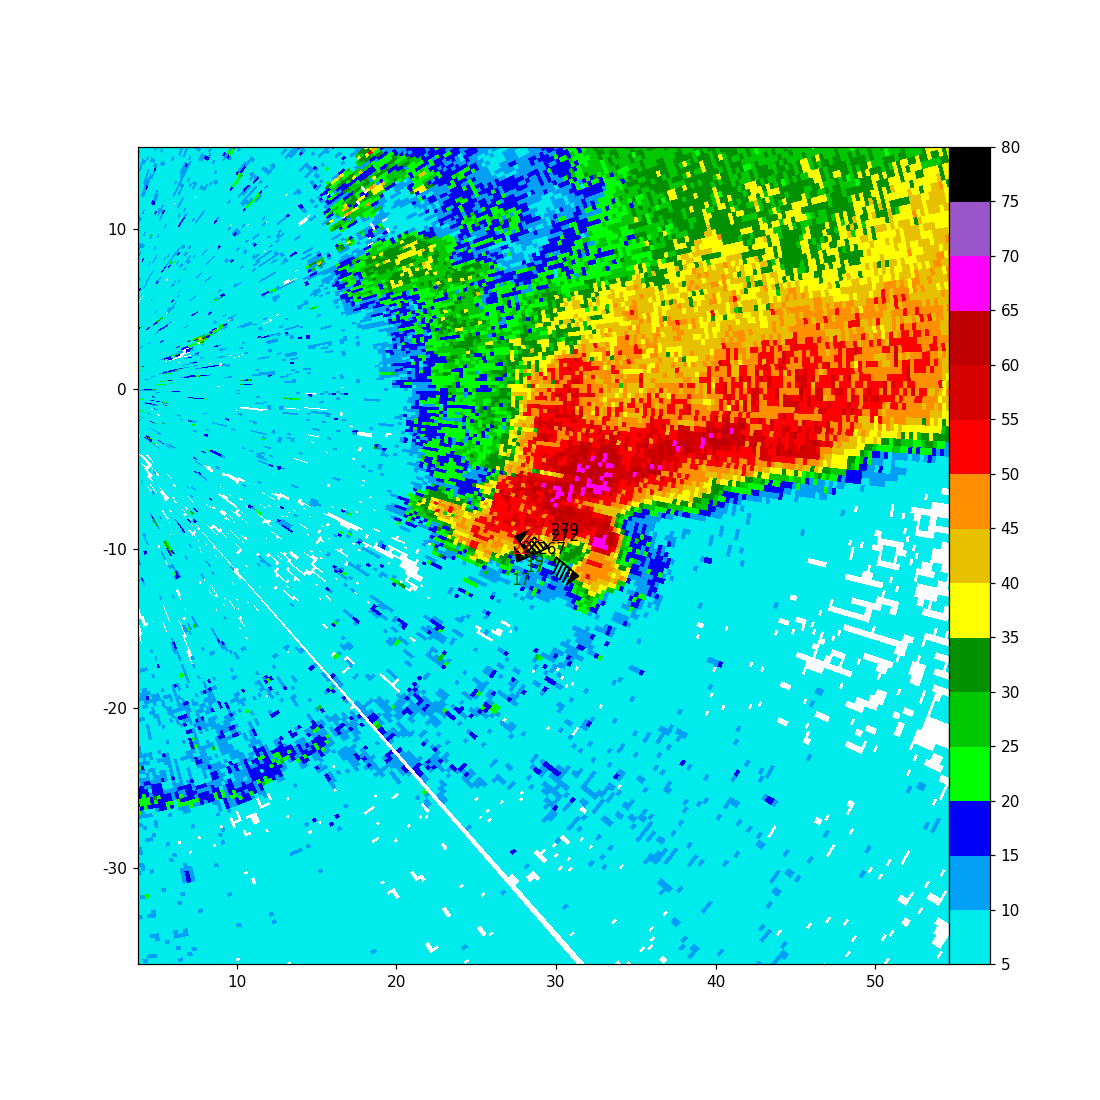

i, sweeptime =  2009-06-09 23:39:31


<IPython.core.display.Javascript object>


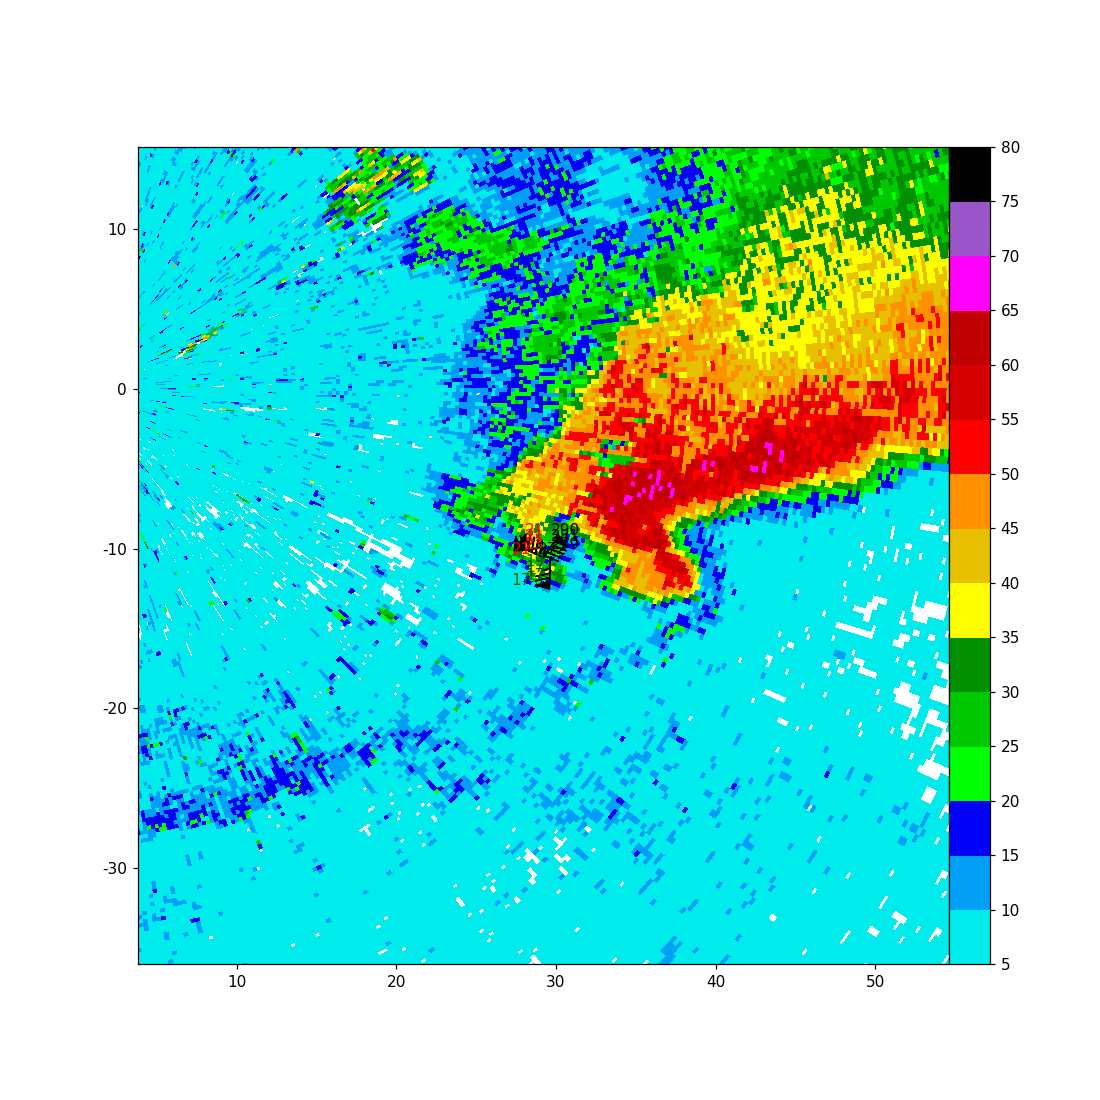

i, sweeptime =  2009-06-09 23:44:09


<IPython.core.display.Javascript object>


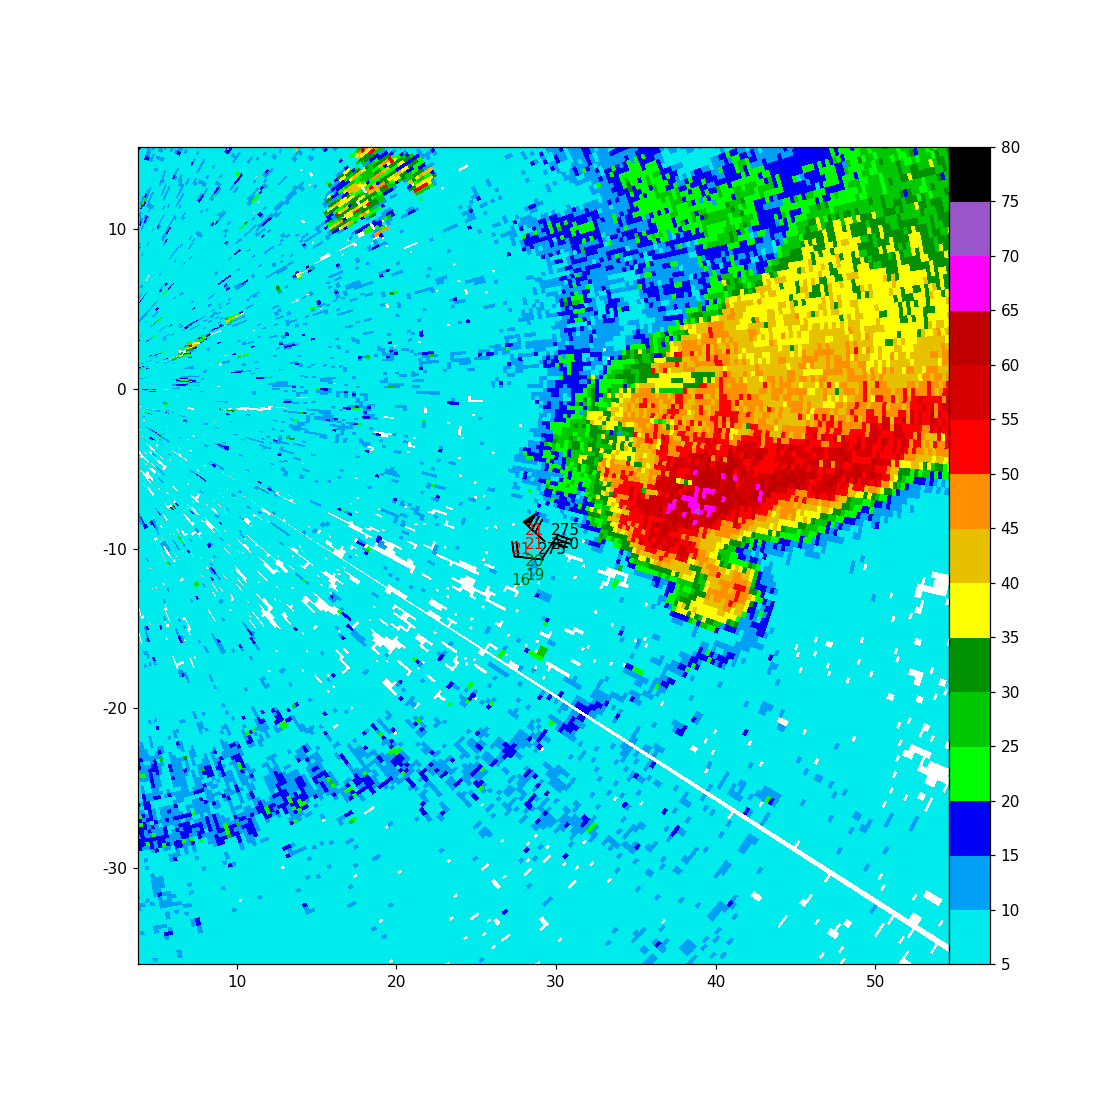

i, sweeptime =  2009-06-09 23:48:49


<IPython.core.display.Javascript object>


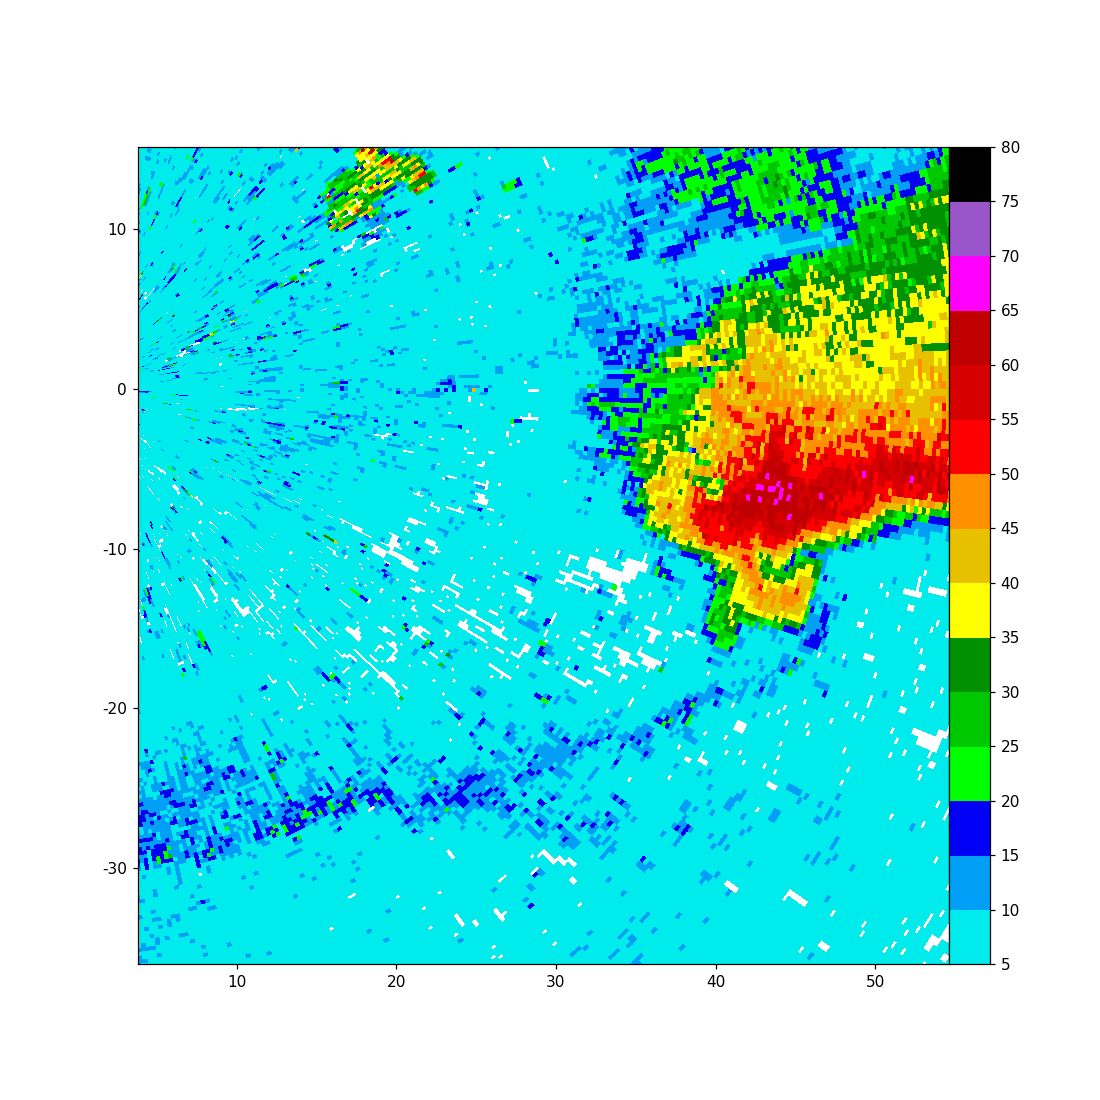

i, sweeptime =  2009-06-09 23:53:27


<IPython.core.display.Javascript object>


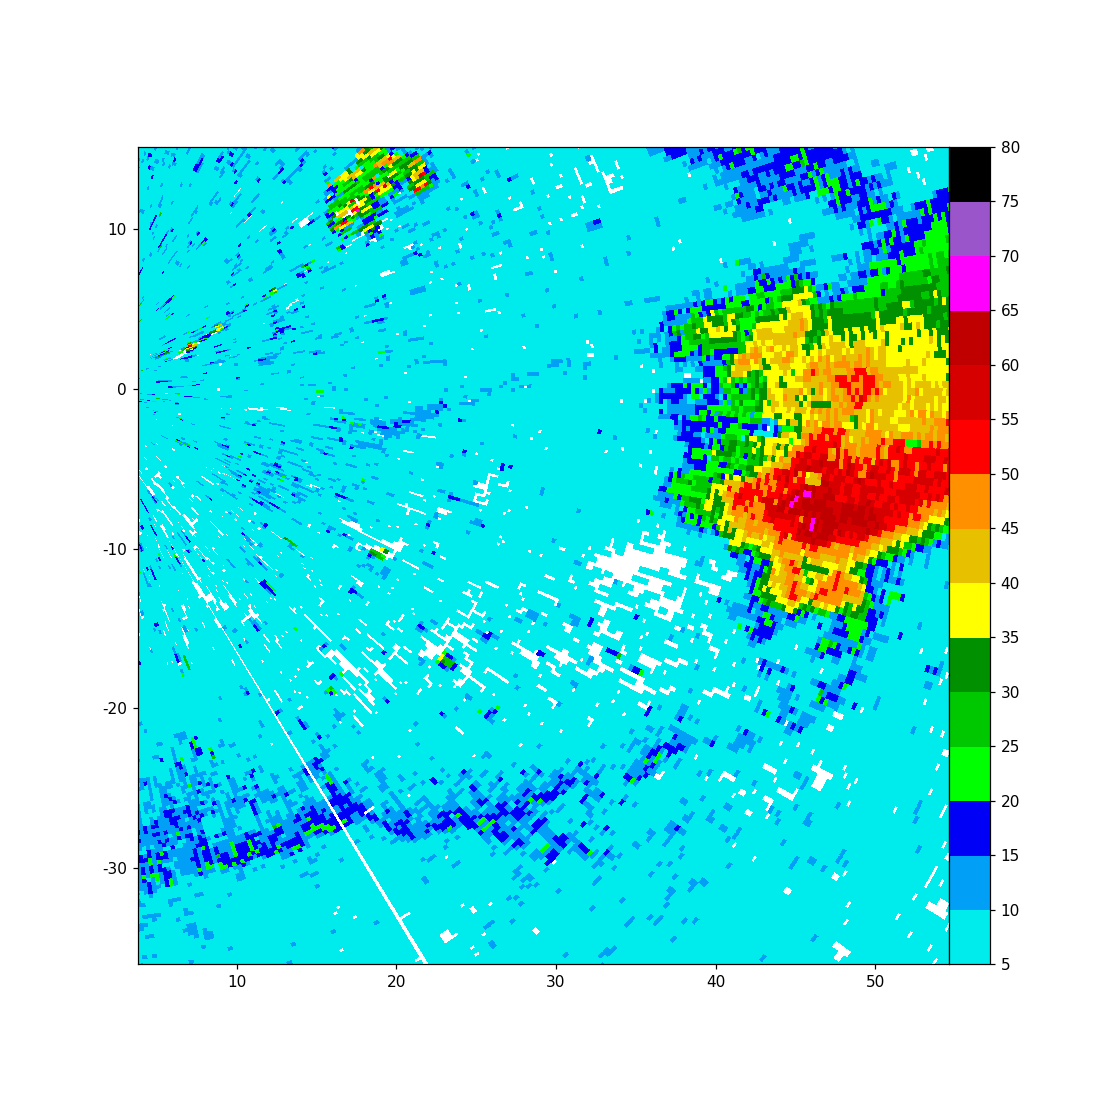

i, sweeptime =  2009-06-09 23:58:06


<IPython.core.display.Javascript object>


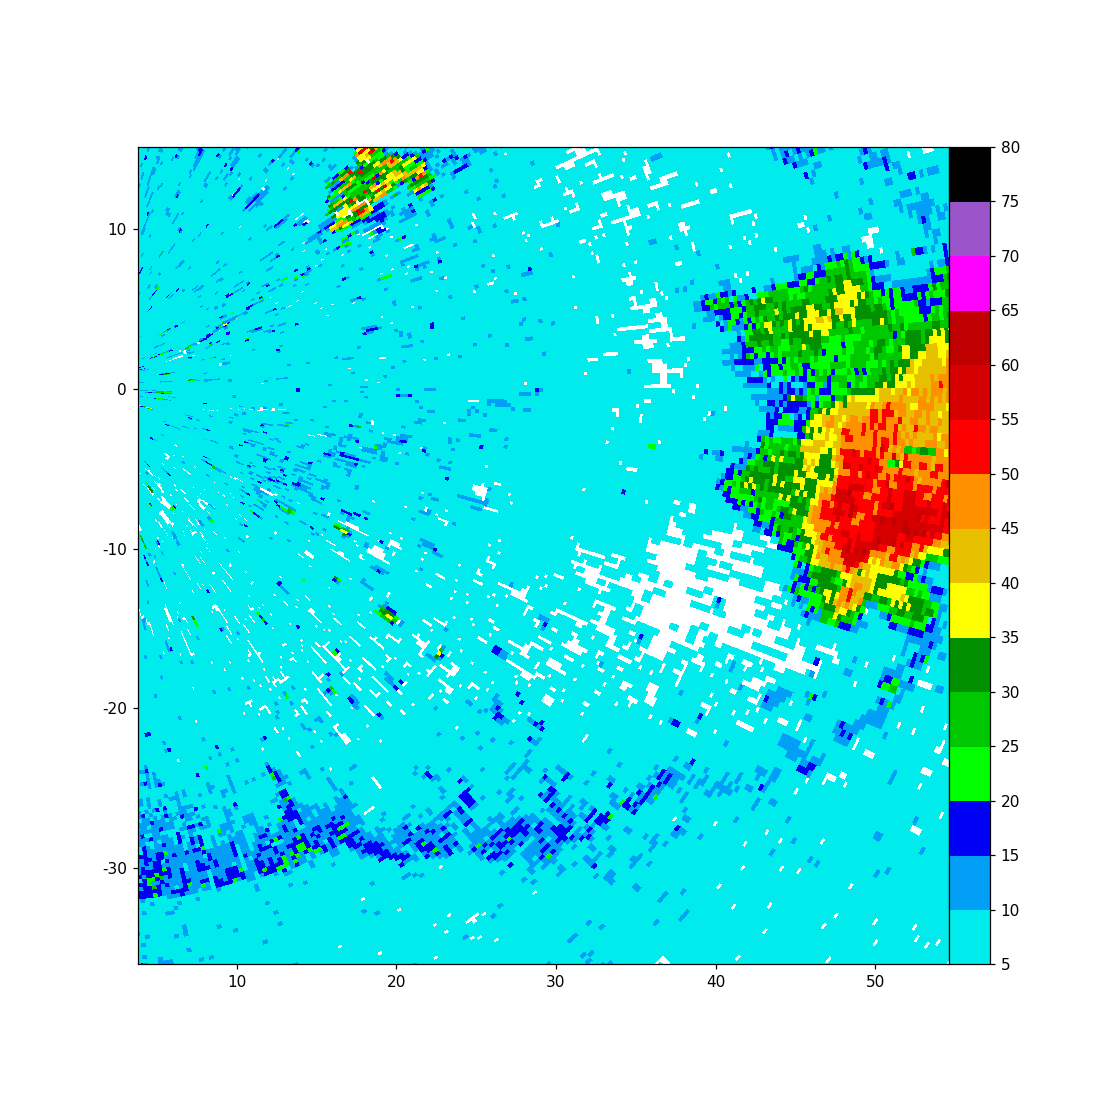

In [8]:
# Go ahead and read in the conventional data at the sweeptimes and plot them:
%matplotlib notebook
radlims = [0.0,250000.,0.,360.]
plotlims = [-1,-1,-1,-1]
ovrmap = False
ovrdis = False
dis_name_list = None
dxy_list = None
fields_D_list = None
deg2rad = np.pi/180.

# Grab radar location information from the first sweep in radar_dict
radarsweep = radar_dict[casedate]['radarsweeplist'][0]
rlat = radarsweep.latitude['data'][0]
rlon = radarsweep.longitude['data'][0]
print rlat,rlon
print radarsweep.projection

# Read conventional data at radar sweeptimes
read_convdata_at_sweeptimes(casedate, dis_dict, radar_dict)

# Find disdrometer lat/lons and convert them to cartesian coordinates relative to radar lat/lon

get_dis_locs_relative_to_radar(casedate, dis_dict, radar_dict)

dxlist = [i[0] for i in dis_dict[casedate]['dradloclist']]
dylist = [i[1] for i in dis_dict[casedate]['dradloclist']]

# Set plotting limits to center on the disdrometer locations 
if plotlims[0] == -1:
    Dxmin = min(dxlist)
    Dxmax = max(dxlist)
    Dymin = min(dylist)
    Dymax = max(dylist)
    plotlims = [Dxmin - 25000., Dxmax + 25000., Dymin - 25000., Dymax + 25000.]

# Extract stuff from radar dictionary
sweeptimelist = radar_dict[casedate]['sweeptimelist']
radarsweeplist = radar_dict[casedate]['radarsweeplist']
outfieldnames = radar_dict[casedate]['outfieldnameslist'][0] # Just need first entry

# Extract stuff from disdrometer dictionary
templist = dis_dict[casedate]['convdata_at_sweeptimes']['temp']
dewpointlist = dis_dict[casedate]['convdata_at_sweeptimes']['dewpoint']
pressurelist = dis_dict[casedate]['convdata_at_sweeptimes']['pressure']
windspdavgveclist = dis_dict[casedate]['convdata_at_sweeptimes']['windspdavgvec']
winddiravgveclist = dis_dict[casedate]['convdata_at_sweeptimes']['winddiravgvec']
    
for i, sweeptime in enumerate(sweeptimelist):
    print "i, sweeptime = ", sweeptime
    figlist, gridlist = radar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
                                              ovrdis, dis_name_list, dxy_list, fields_D_list)
    ax = gridlist[0][0]
    
    for j, Dx, Dy in zip(xrange(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='red')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))
    
    figlist[0].canvas.draw()
    figlist[0].set_size_inches(10., 10., forward = True)
    # if(field_D != None):
    #     ax.annotate(disfmtstr.format(field_D),(Dx+250.,Dy-250.),clip_on=True)
    #plt.savefig('/Users/ddawson/temp_VSE/fig{:04d}.png'.format(i),dpi=200)
    #plt.close(figlist[0])

[datetime.datetime(2009, 6, 9, 23, 16, 20), datetime.datetime(2009, 6, 9, 23, 20, 57), datetime.datetime(2009, 6, 9, 23, 25, 37), datetime.datetime(2009, 6, 9, 23, 30, 15), datetime.datetime(2009, 6, 9, 23, 34, 52), datetime.datetime(2009, 6, 9, 23, 39, 31), datetime.datetime(2009, 6, 9, 23, 44, 9), datetime.datetime(2009, 6, 9, 23, 48, 49), datetime.datetime(2009, 6, 9, 23, 53, 27), datetime.datetime(2009, 6, 9, 23, 58, 6)]
3
[False False  True  True  True  True  True False False False]
[41990.721542069776, 37808.838005046055, 33581.663310581636, 29384.682721077683, 25202.79918405396, 20990.721542069776, 16793.740952565822, 12566.566258101408, 8369.585668597454, 4157.508026613268]
[33581.663310581636, 29384.682721077683, 25202.79918405396, 20990.721542069776, 16793.740952565822]
[41990.721542069776, 37808.838005046055, 12566.566258101408, 8369.585668597454, 4157.508026613268]


<IPython.core.display.Javascript object>


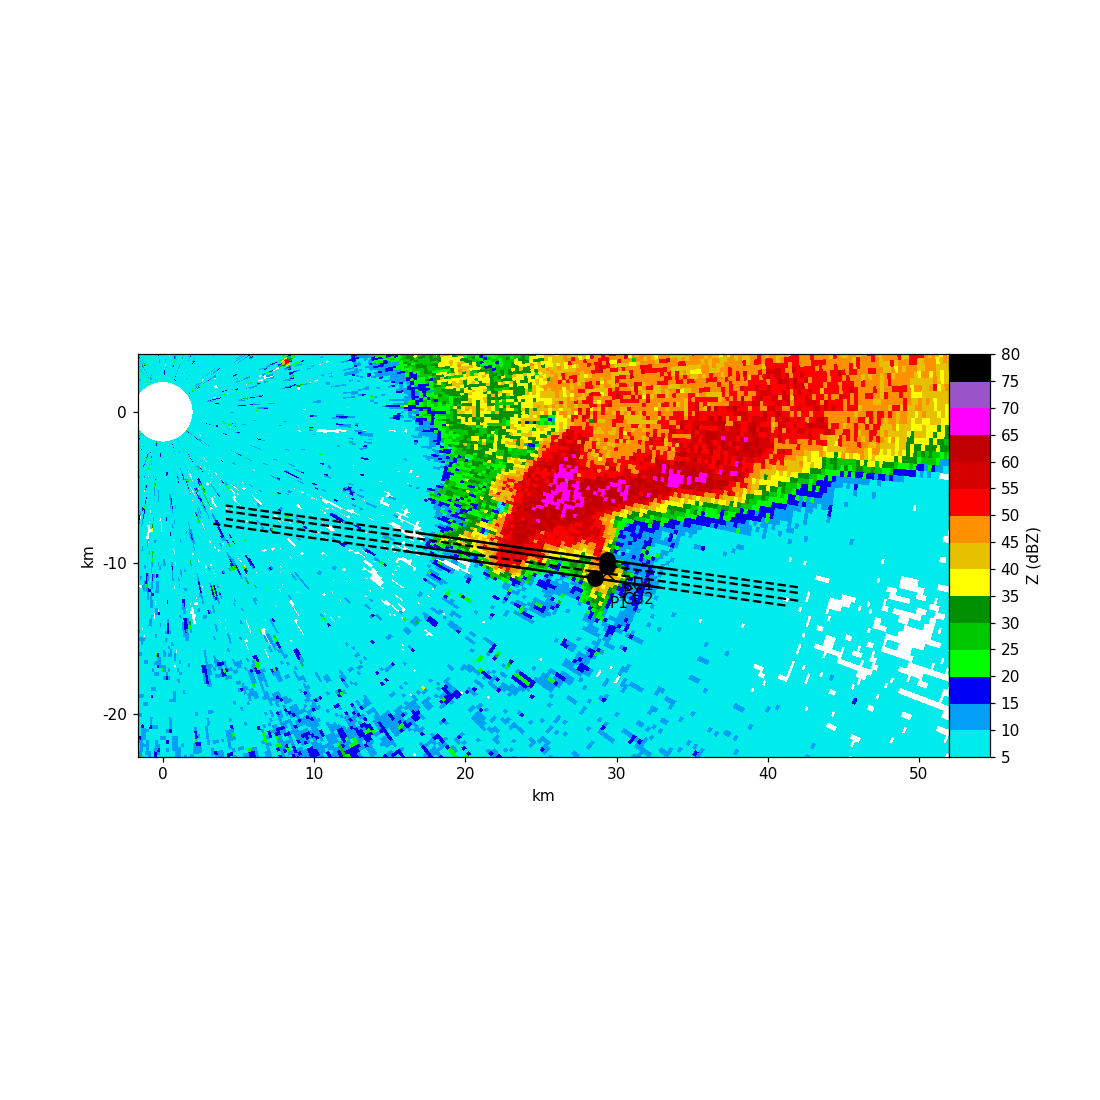

In [9]:
# Make a plot of the disdrometer transects through the storm, 
# choosing a representative sweeptime as the backdrop
plotdir = '/Users/dawson29/Projects/VORTEX2/model_DSD_study/pyPIPS_plots/'+casedate
sweeptimeref = radar_dict[casedate]['sweeptime_ref']
ustorm, vstorm = radar_dict[casedate]['feature_motion']
sweepindex = np.searchsorted(sweeptimelist, sweeptimeref)
sweepdtrel = [(sweeptime - sweeptimeref).total_seconds() for sweeptime in sweeptimelist]
deployed = dis_dict[casedate]['convdata_at_sweeptimes']['deployed']
# dxsr = [[dx - ustorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dx, dp in zip(dxlist, deployed)]
# dysr = [[dy - vstorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dy, dp in zip(dylist, deployed)]
dxsr = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxlist]
dysr = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dylist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsr_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsr, deployed)]
dxsr_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsr, deployed)]
dysr_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysr, deployed)]
dysr_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysr, deployed)]

print sweeptimelist
print sweepindex
print deployed[0]
print dxsr[0]
print dxsr_d[0]
print dxsr_nd[0]

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.nanmin(np.array(dxsr))
Dxmax = np.nanmax(np.array(dxsr))
Dymin = np.nanmin(np.array(dysr))
Dymax = np.nanmax(np.array(dysr))
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]
# plotlims = [15000., 45000., -15000., 0.]

figlist, gridlist = radar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[sweepindex], ovrmap, 
                                              ovrdis, dis_name_list, dxy_list, fields_D_list)
ax = gridlist[0][0]

dis_names = dis_dict[casedate]['dis_names']

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxlist)), dxsr, dysr, dxsr_d, dysr_d, 
                                                          dxsr_nd, dysr_nd, deployed, dis_names):
    ax.plot(dx_d, dy_d, ls='-', c='k')
    ax.plot(dx, dy, ls='--', c='k')
    if dp[sweepindex]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)

gridlist[0].cbar_axes[0].set_ylabel('Z (dBZ)')
ax.set_xlabel('km')
ax.set_ylabel('km')
    
figlist[0].canvas.draw()
figlist[0].set_size_inches(10., 10., forward = True)

figpath = os.path.join(plotdir, casedate+'_transects_radar.png')
plt.savefig(figpath, dpi=300)

In [10]:
# Read in the model information for the case we want
set_dh(casedate, model_dict, radar_dict)
dh = model_dict[casedate]['DataHandler']
modeltime_ref = model_dict[casedate]['modeltime_ref']

# Read in the model grid info
xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()
dx = xc[0,0,1]-xc[0,0,0]
dy = yc[0,1,0]-yc[0,0,0]
xe1d = xe[0, 0, :]
ye1d = ye[0, :, 0]
xcplot = xc[0, :, :]
ycplot = yc[0, :, :]
xeplot = xe[0, :, :]
yeplot = ye[0, :, :]
xcorplot, ycorplot = pm.computecorners(xeplot, yeplot)
    
# Read in the reflectivity field from the model

# dp_data, consts = dh.loadMicrophysics()
# # Extract the lowest model level and store in dp_data_2D
# dp_data_2D = {}
# for key, dat in dp_data.iteritems():
#     dp_data_2D[key] = dat[:,:,0]
# dp_data_plot = {}
# for key, dat in dp_data_2D.iteritems():
#     dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()
# dp_data_plot_list.append(dp_data_plot)

Zmod = dh.loadModelReflectivity()
Zmodplot = Zmod[:, :, 0].T
# Zmodplot_list.append(Zmodplot)

<IPython.core.display.Javascript object>


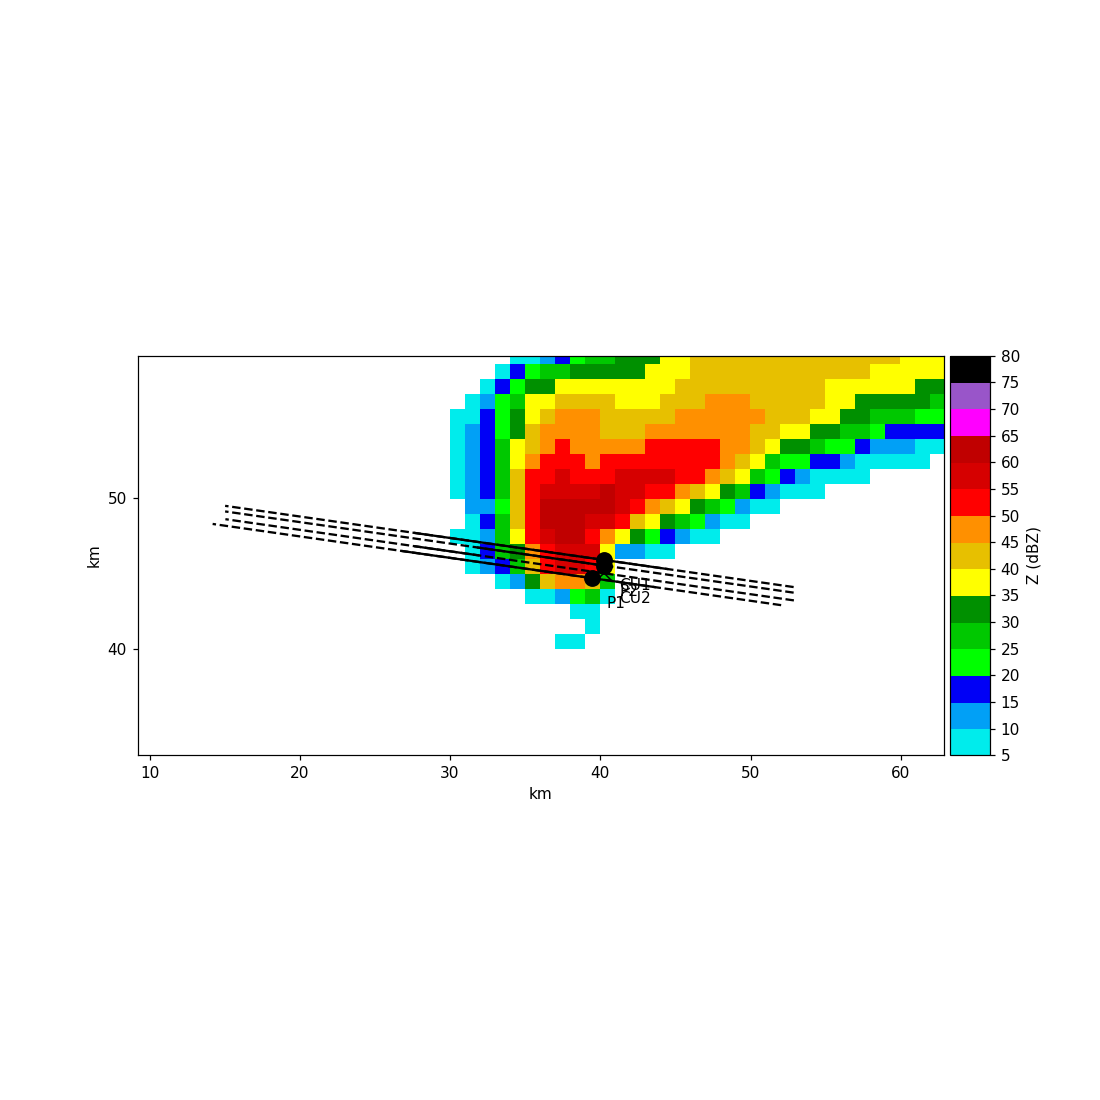

[9200.340825226904, 62881.79567797836] [32901.06185200058, 59510.6277744495]
10000.0 10000.0


In [11]:
# Make a plot of the disdrometer transects through the *simulated* storm, 
# choosing a representative *model time* as the backdrop

# First we need to set up a list of x and y coordinates within the model for each disdrometer. We'll use the
# coordinates computed relative to the radar above, but shifted so that they are in the same relative position
# to the model storm (necessarily subjective) as they are for the observed storm.

# For example, we'll use P2's coordinates near the tip of the hook for 5 June 2009.

xref_model, yref_model = model_dict[casedate]['ref_coords']

xref_rad = dxlist[-1]
yref_rad = dylist[-1]

xshift = xref_model - xref_rad
yshift = yref_model - yref_rad

dxmodlist = [dx + xshift for dx in dxlist]
dymodlist = [dy + yshift for dy in dylist]

# Using sweeptimelist here to facilitate matching with the disdrometer locations on the radar plot.
sweepdtrel = [(sweeptime - modeltime_ref).total_seconds() for sweeptime in sweeptimelist]
dxsrm = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxmodlist]
dysrm = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dymodlist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsrm_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsrm, deployed)]
dxsrm_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsrm, deployed)]
dysrm_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysrm, deployed)]
dysrm_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysrm, deployed)]

# Get the index where the relative time is zero. Use this below to put the probes
# at the proper location along the transect corresponding to the reference time.
modelindex_ref = np.searchsorted(sweepdtrel, 0.)

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.array(dxsrm).min()
Dxmax = np.array(dxsrm).max()
Dymin = np.array(dysrm).min()
Dymax = np.array(dysrm).max()
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]

fig = None
ax = None
ptype = 2
xlim = [plotlims[0], plotlims[1]]
ylim = [plotlims[2], plotlims[3]]
clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
cformat = None
ovrmap = False
gis_info = None
numovr = 0
axesticks = [10000., 10000.]

fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                            cbarlevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                            axesticks)

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxmodlist)), dxsrm, dysrm, dxsrm_d, dysrm_d, 
                                                          dxsrm_nd, dysrm_nd, deployed, dis_names):
    ax.plot(dx, dy, ls='--', c='k')
    ax.plot(dx_d, dy_d, ls='-', c='k')
    if dp[modelindex_ref]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)
    
fig.canvas.draw()
fig.set_size_inches(10., 10., forward = True)
figpath = os.path.join(plotdir, casedate+'_transects_model.png')
plt.savefig(figpath, dpi=300)